<a href="https://colab.research.google.com/github/amirsalhuv/MassDetector/blob/main/IOU_loss_patch_model_2_classes_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.2 Imports

In [ ]:
####
# For image manipulation
import cv2
from PIL import Image
import numpy as np
import pandas as pd

# Image loading saving, copy ,measuring time
import time, json, os
import datetime
import pickle
# For plots
import matplotlib.pyplot as plt
import shutil
from tqdm import tqdm
import random

# Pytorch
import torch
from torch.utils.data import DataLoader,Dataset
from torch.nn import BCELoss
from torchvision.transforms import Compose, ToTensor, Normalize
from torch import nn,optim
import torch.nn.functional as F
from torchvision import models
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split
from torchvision.models import vgg16_bn, VGG16_BN_Weights

# 1.3 Definitions


In [ ]:
# Amir Salhuv:
dataset_dir = '/content/drive/MyDrive/Project_OpenU/CBIS-DDSM/'

# Yonatan Salhuv:
#dataset_dir = '/content/drive/MyDrive/'

data_folder = dataset_dir + 'Latest_model_data/'
patches_folder = data_folder + 'Patches/'
models_folder = dataset_dir + 'Full_model/Models/'
run_mode = "evaluate_model"

# Classes and batch size
n_classes=2
batch_size = 16

# 3- Prepare the data for the model train
1. Cut the relevant patch according to the mask bounding boxes
2. store it locally (for as an .npy)


##3.1 Validation pathces

In [ ]:
if run_mode == "cut_pathces":

  # Define the minimal ROI
  min_roi_size = 100

  # Padding size
  pad = 0

  # Create an empty list for validation set
  X_val = list()
  y_val = list()

  # For visulazing the image and mask compared to origin
  x_origin = list()
  y_origin = list()

  # Starting with validation images:
  val_image_dir = data_folder +'images/val'
  val_mask_dir = data_folder + 'masks/val'
  val_list = sorted(os.listdir(val_image_dir))

  # Steps:
  # 1. take an image
  # 2. Cut a window around the mask boundries
  # 3. append to whole list

  for i,image_path in tqdm(enumerate(val_list)):

    # step #1 - read the image and mask
    img = cv2.imread(os.path.join(val_image_dir, image_path))
    mask = cv2.imread(os.path.join(val_mask_dir, image_path),cv2.IMREAD_GRAYSCALE)*255

    # Find contours in the binary image
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # For each contour, find the bounding rectangle and create a new image
    for _, cnt in enumerate(contours):
      x, y, w, h = cv2.boundingRect(cnt)
      if w*h > min_roi_size:

        # add the origin image (so we can later view it)
        x_origin.append(image_path)
        y_origin.append(image_path)

        # Add to train set
        X_val.append(cv2.resize(img[max(0,y-pad):min(mask.shape[0]-1,y+h+pad),max(0,x-pad):min(mask.shape[1]-1,x+w+pad),:],(256,256)))
        y_val.append(cv2.resize(mask[max(0,y-pad):min(mask.shape[0]-1,y+h+pad),max(0,x-pad):min(mask.shape[1]-1,x+w+pad)],(256,256)))

  # Convert and Save the data
  X_val = np.array(X_val)
  y_val = np.array(y_val)
  with open(data_folder + 'X_val.npy', 'wb') as f:
    np.save(f, X_val)
  with open(data_folder + 'y_val.npy', 'wb') as f:
    np.save(f, y_val)


In [ ]:
# Visulize one image
if run_mode == "cut_pathces":

  index = 100
  img = cv2.imread(os.path.join(val_image_dir, x_origin[index]))
  mask = cv2.imread(os.path.join(val_mask_dir, y_origin[index]))*255
  output = [X_val[index],y_val[index],img,mask]
  titles = ['patch','mask patch','original image','original mask']
  # Plot couple of examples
  fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10)) # Define a grid of 2 rows and 3 columns.

  for idx, ax in enumerate(axs.flatten()): # axs.flatten() gives us a 1D array to iterate over.
      ax.imshow(output[idx], cmap='gray')
      ax.set_title(titles[idx])
      ax.axis('off')

  plt.tight_layout()
  plt.show()

## 3.2 Training patches

In [ ]:
if run_mode == "cut_pathces":

  # Define the minimal ROI
  min_roi_size = 100
  # Create an empty list for validation set
  X_train = list()
  y_train = list()

  # For visulazing the image and mask compared to origin
  x_origin = list()
  y_origin = list()

  # Train images:
  train_image_dir = data_folder +'images/train'
  train_mask_dir = data_folder + 'masks/train'
  train_list = sorted(os.listdir(train_image_dir))

  # Steps:
  # 1. take an image
  # 2. Cut a window around the mask boundries
  # 3. append to whole list

  for i,image_path in tqdm(enumerate(train_list)):

    # step #1 - read the image and mask
    img = cv2.imread(os.path.join(train_image_dir, image_path))
    mask = cv2.imread(os.path.join(train_mask_dir, image_path),cv2.IMREAD_GRAYSCALE)*255

    # Find contours in the binary image
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # For each contour, find the bounding rectangle and create a new image
    for _, cnt in enumerate(contours):
      x, y, w, h = cv2.boundingRect(cnt)
      if w*h > min_roi_size:

        # add the origin image (so we can later view it)
        x_origin.append(image_path)
        y_origin.append(image_path)

        # Add to train set
        X_train.append(cv2.resize(img[max(0,y-pad):min(mask.shape[0]-1,y+h+pad),max(0,x-pad):min(mask.shape[1]-1,x+w+pad),:],(256,256)))
        y_train.append(cv2.resize(mask[max(0,y-pad):min(mask.shape[0]-1,y+h+pad),max(0,x-pad):min(mask.shape[1]-1,x+w+pad)],(256,256)))

  # Convert and Save the data
  X_train = np.array(X_train)
  y_train = np.array(y_train)
  with open(data_folder + 'X_train.npy', 'wb') as f:
    np.save(f, X_train)
  with open(data_folder + 'y_train.npy', 'wb') as f:
    np.save(f, y_train)


In [ ]:
# Visulize one image
if run_mode == "cut_pathces":

  index = 100
  img = cv2.imread(os.path.join(train_image_dir, x_origin[index]))
  mask = cv2.imread(os.path.join(train_mask_dir, y_origin[index]))*255
  output = [X_train[index],y_train[index],img,mask]
  titles = ['patch','mask patch','original image','original mask']
  # Plot couple of examples
  fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10)) # Define a grid of 2 rows and 3 columns.

  for idx, ax in enumerate(axs.flatten()): # axs.flatten() gives us a 1D array to iterate over.
      ax.imshow(output[idx], cmap='gray')
      ax.set_title(titles[idx])
      ax.axis('off')

  plt.tight_layout()
  plt.show()

# 4- Model architecture

## 4.1 Define the Unet block

In [ ]:
if run_mode == 'training_model' or run_mode == 'evaluate_model':

  def double_conv(in_channels, out_channels):
      return nn.Sequential(
          nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(inplace=True),
          nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(inplace=True)
      )


  def up_conv(in_channels, out_channels):
      return nn.ConvTranspose2d(
          in_channels, out_channels, kernel_size=2, stride=2
      )


  class VGGUnet(nn.Module):
    #  VGG-16 (with BN) encoder.

      def __init__(self, encoder, *, pretrained=False, out_channels=1):
          super().__init__()

          self.encoder = encoder(pretrained=pretrained).features
          self.block1 = nn.Sequential(*self.encoder[:6])
          self.block2 = nn.Sequential(*self.encoder[6:13])
          self.block3 = nn.Sequential(*self.encoder[13:20])
          self.block4 = nn.Sequential(*self.encoder[20:27])
          self.block5 = nn.Sequential(*self.encoder[27:34])

          self.bottleneck = nn.Sequential(*self.encoder[34:])
          self.conv_bottleneck = double_conv(512, 1024)

          self.up_conv6 = up_conv(1024, 512)
          self.conv6 = double_conv(512 + 512, 512)
          self.up_conv7 = up_conv(512, 256)
          self.conv7 = double_conv(256 + 512, 256)
          self.up_conv8 = up_conv(256, 128)
          self.conv8 = double_conv(128 + 256, 128)
          self.up_conv9 = up_conv(128, 64)
          self.conv9 = double_conv(64 + 128, 64)
          self.up_conv10 = up_conv(64, 32)
          self.conv10 = double_conv(32 + 64, 32)
          self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)

      def forward(self, x):
          block1 = self.block1(x)
          block2 = self.block2(block1)
          block3 = self.block3(block2)
          block4 = self.block4(block3)
          block5 = self.block5(block4)

          bottleneck = self.bottleneck(block5)
          x = self.conv_bottleneck(bottleneck)

          x = self.up_conv6(x)
          x = torch.cat([x, block5], dim=1)
          x = self.conv6(x)

          x = self.up_conv7(x)
          x = torch.cat([x, block4], dim=1)
          x = self.conv7(x)

          x = self.up_conv8(x)
          x = torch.cat([x, block3], dim=1)
          x = self.conv8(x)

          x = self.up_conv9(x)
          x = torch.cat([x, block2], dim=1)
          x = self.conv9(x)

          x = self.up_conv10(x)
          x = torch.cat([x, block1], dim=1)
          x = self.conv10(x)

          x = self.conv11(x)

          x = torch.sigmoid(x)

          return x

## 4.2 Define the loss function

### 4.2.1 Option 1 - iou loss

In [ ]:
if run_mode == 'training_model':

  def iou_loss(pred, target):
      smooth = 1.0
      print(f'shapes: pred {pred.shape} target {target.shape}')
      iflat = pred.view(-1)
      tflat = target.view(-1)
      intersection = (iflat * tflat).sum()
      return 1 - ((intersection + smooth) / (iflat.sum() + tflat.sum() - intersection + smooth))

### 4.2.2 Option 2 - iou loss per image with penalty

In [ ]:
if run_mode == 'training_model':

  # Training loss function
  '''
  def iou_per_image(pred, target, smooth=1.0, epsilon=1e-3,min_iou= 0.7):
      pred = pred.view(pred.shape[0], -1)  # Flatten each image separately
      target = target.view(target.shape[0], -1)  # Flatten each image separately

      intersection = (pred * target).sum(dim=1)  # Compute intersection per image
      union = (pred + target).sum(dim=1) - intersection  # Compute union per image

      # Calculate the IOU per image
      iou_per_image = (intersection + smooth) / (union + smooth)  # Compute IoU per image

      # Add the penalty for zero intersection
      for i,_ in enumerate(iou_per_image):
        if torch.mean(iou_per_image) > min_iou:
          #print(torch.mean(iou_per_image))
          if iou_per_image[i] < epsilon:
            # Assign a value that match the entire batch value
            iou_per_image[i] = -1*iou_per_image.size(0)//8

      # Return the average per all images in batch
      iou = torch.mean(iou_per_image)

      return 1 - iou  # Return IoU loss per image'''

  # Validation loss function
  def iou_loss_per_image(pred, target, smooth=1.0):
      pred = pred.view(pred.shape[0], -1)  # Flatten each image separately
      target = target.view(target.shape[0], -1)  # Flatten each image separately

      intersection = (pred * target).sum(dim=1)  # Compute intersection per image
      union = (pred + target).sum(dim=1) - intersection  # Compute union per image

      # Calculate the IOU per image
      iou_per_image = (intersection + smooth) / (union + smooth)  # Compute IoU per image

      # Return the average per all images in batch
      iou = torch.mean(iou_per_image)

      return 1-iou  # Return 1-IoU as loss per image

## 5.3 Define the dataloader

In [ ]:
if run_mode == 'training_model' or run_mode == 'evaluate_model':

  #Assuming image/mask is from shape (256,256,C1/C2)
  class CustomDataset(Dataset):
      def __init__(self, images, masks, train=True):

          self.images = images
          self.masks = masks
          self.train = train

        # In training, apply the following transformations
          self.train_image_transforms = transforms.Compose([
              transforms.Resize((224, 224)), # Resize to fit VGG16 input shape
              transforms.ToTensor(),
              transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # VGG16 normalization
              transforms.RandomHorizontalFlip(),
              transforms.RandomVerticalFlip(),
              transforms.RandomRotation(90),
          ])

          # In training, apply the following transformations (including random transformation)
          self.train_mask_transforms = transforms.Compose([

              transforms.Resize((224, 224)),
              transforms.ToTensor(),
              transforms.RandomHorizontalFlip(),
              transforms.RandomVerticalFlip(),
              transforms.RandomRotation(90),
          ])

          # In training, apply the following transformations (Excluding random transformation)
          self.test_image_transforms = transforms.Compose([
              transforms.Resize((224, 224)),
              transforms.ToTensor(),
              transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
          ] )

          # In testing, apply the following transformations (Excluding random transformation)
          self.test_mask_transforms = transforms.Compose([
              transforms.Resize((224, 224)),
              transforms.ToTensor(),
          ])

      def __len__(self):
          return len(self.images)

      def __getitem__(self, idx):

          # Get the image index
          #image = self.images[idx]*255
          image = self.images[idx]

          # Convert the numpy array to a PIL Image
          image = Image.fromarray(image.astype('uint8'))

          # Get the corresponding mask index (need to reshape to (256,256) to convert to PIL later
          #mask = self.masks[idx] *255
          mask = self.masks[idx]

          # convert to fit to PIL image (256,256,1)-> (256,256)
          #mask = mask.squeeze()

          # convert to PIL image (not before updating from [0,1] to [0,255]), it will be normalized later
          mask = Image.fromarray(mask.astype('uint8'))

          if self.train:

              # make a seed with numpy generator
              seed = np.random.randint(2147483647)
              random.seed(seed)
              torch.manual_seed(seed)
              image = self.train_image_transforms(image)

              random.seed(seed)
              torch.manual_seed(seed)
              mask = self.train_mask_transforms(mask)

          else:
              image = self.test_image_transforms(image)
              mask = self.test_mask_transforms(mask)

          return image, mask


  # Load X and y from pickle files

  X_train = np.load(data_folder + 'X_train.npy')
  y_train = np.load(data_folder + 'y_train.npy')
  X_val = np.load(data_folder + 'X_val.npy')
  y_val = np.load(data_folder + 'y_val.npy')


  train_dataset = CustomDataset(X_train, y_train, train=True)
  val_dataset = CustomDataset(X_val, y_val, train=False)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
if run_mode == 'testing_dataloader':
  # define the transform
  train_image_transforms = transforms.Compose([
    transforms.Resize((256, 256)), # Resize to fit VGG16 input shape
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # VGG16 normalization
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(100),

  ])

  # Load the image and convert to PIL image
  # Convert array to Image
  #image= X[0]*255
  image= X_train[0]
  img = Image.fromarray(image.astype('uint8'))
  img2= img

  # make a seed with numpy generator
  seed = np.random.randint(2147483647)
  random.seed(seed)
  torch.manual_seed(seed)
  img = train_image_transforms(img)

  # Assuming your DataLoader returns a batch of images and labels
  # we will display the first image from the batch

  def unnormalize(tensor):
      mean = torch.tensor([0.485, 0.456, 0.406])
      std = torch.tensor([0.229, 0.224, 0.225])
      for t, m, s in zip(tensor, mean, std):
          t.mul_(s).add_(m)
      return tensor

  img = unnormalize(img)
  img = transforms.ToPILImage()(img).convert("RGB")


  # In training, apply the following transformations (including random transformation)
  train_mask_transforms = transforms.Compose([

      transforms.Resize((256, 256)),
      transforms.ToTensor(),
      transforms.RandomHorizontalFlip(), # todo - return back
      transforms.RandomVerticalFlip(),
      transforms.RandomRotation(100),
  ])

  # Convert array to Image
  #mask1= y[0] *255
  mask1= y_train[0]
  mask1 = mask1.reshape((256,256))
  mask = Image.fromarray(mask1.astype('uint8'))
  random.seed(seed)
  torch.manual_seed(seed)
  mask = train_mask_transforms(mask)
  mask = transforms.ToPILImage()(mask).convert("RGB")


  # Create subplots
  fig, axs = plt.subplots(1, 4, figsize=(10, 5))  # adjust the size as needed

  # Show the images
  axs[0].imshow(img)
  axs[0].axis('off')  # to hide the axis
  axs[0].set_title('Image 1')

  axs[1].imshow(img2)
  axs[1].axis('off')  # to hide the axis
  axs[1].set_title('Image 2')

  axs[2].imshow(mask)
  axs[2].axis('off')  # to hide the axis
  axs[2].set_title('Mask')

  axs[3].imshow((np.array(mask))*img)
  axs[3].axis('off')  # to hide the axis
  axs[3].set_title('Image with Mask')

  plt.show()


# 5.4 train

### 5.4.1 Define stop and update learning rate conditions

In [ ]:
if run_mode == 'training_model':
  NUM_OF_EPOCHS_TO_REDUCE_LR = 50
  NUM_OF_EPOCHS_TO_STOP = 100


  def model_checkpoint(valid_loss,best_val_loss,epoch,best_epoch,lr,last_lr_update,stop_training=False):
    if valid_loss < best_val_loss:

      # Imporvement in current validation loss, udpate best epoch
      print(f"Validation was improved, updated best loss: {valid_loss},best_epoch:{epoch},lr:{lr}\n")
      best_val_loss = valid_loss
      best_epoch = epoch
      last_lr_update = epoch

      # Save the model
      torch.save(model.state_dict(), models_folder + 'Patch_model_padding_2_classes.pth')


    # Stop training if the validation loss doesn't improve for 10 epochs
    else:
      if epoch - best_epoch >= NUM_OF_EPOCHS_TO_STOP:
        print(f"No improvement in validation loss for {NUM_OF_EPOCHS_TO_STOP} epochs, stopping.")
        stop_training = True

      # If need only to reduce learning rate
      elif epoch - last_lr_update >= NUM_OF_EPOCHS_TO_REDUCE_LR:
        last_lr_update = epoch
        lr/=10
        print(f"No improvement in validation loss for {NUM_OF_EPOCHS_TO_REDUCE_LR} epochs, reducing learning rate to {lr}.\n")

    return stop_training,best_epoch,best_val_loss,lr,last_lr_update


### 5.4.2 Metrics

In [ ]:
def iou_score(output, target):
    smooth = 1e-6
    #if torch.is_tensor(output):
    #    output = torch.sigmoid(output).data.cpu().numpy()
    #if torch.is_tensor(target):
    #    target = target.data.cpu().numpy()
    output = output.cpu().numpy() > 0.5
    target = target.cpu().numpy() > 0.5
    intersection = (output & target).sum(axis=(1,2,3))
    union = (output | target).sum(axis=(1,2,3))
    iou = np.mean((intersection + smooth) / (union + smooth))*output.shape[0]
    intersection_over_union = (intersection + smooth) / (union + smooth)
    return iou,intersection_over_union


### 5.4.3 Train the model

In [ ]:
if run_mode == 'training_model':

  # Specify device
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  # Assume that we are on a CUDA machine, then this should print a CUDA device:
  print(f'Working on device={device}')

  # Learning rate at start
  lr = 0.001

  # Define the model
  model=  VGGUnet(models.vgg16_bn, pretrained=True, out_channels=1).to(device)

  # Define the optimizer
  optimizer = optim.Adam(model.parameters(), lr=lr)


  def train_model(model, training_loader, valid_loader, n_epochs,lr,batch_size):

      # Init all values
      best_epoch = 1
      valid_loss = 0
      best_val_loss = float('inf')
      last_lr_update = best_epoch

      for epoch in range(n_epochs):
          model.train()

          train_loss = 0
          for images, masks in training_loader:
              images = images.to(device)
              masks = masks.to(device)

              # Forward pass
              outputs = model(images)
              #loss = iou_loss(outputs, masks)
              loss = iou_loss_per_image(outputs, masks)

              # Backward and optimize
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()

              train_loss += loss.item() * images.size(0)

          # validate-the-model
          model.eval()
          valid_loss = 0
          with torch.no_grad():

              # Init the list of the scores
              iou_scores = []
              intersections = []
              num_batches = len(val_loader)

              # Go over all validation set
              for images, masks in valid_loader:
                  images = images.to(device)
                  masks = masks.to(device)

                  outputs = model(images)
                  loss = iou_loss_per_image(outputs, masks)
                  valid_loss += loss.item() * images.size(0)

                  # Metrices
                  # Iou
                  iou,intersection = iou_score(outputs, masks)
                  iou_scores.append(iou)
                  intersections.append(intersection)

          # Divide the loss*images_in_batch/batch_size with total set to get the average
          train_loss = train_loss / len(y_train)

          # Divide the loss*images_in_batch/batch_size with total set to get the average
          valid_loss = valid_loss / len(y_val)

          # Metrices
          # Merge the arrays
          merged_array = np.concatenate(intersections)
          print(f"number of misdetection: {np.sum(merged_array<0.1)}, misdetection rate: {100*np.sum(merged_array<0.1)/merged_array.shape[0]:.2f}%")
          #print(f"merged array : {merged_array}\n\n\n")
          print(f'Average IOU: {sum(iou_scores)/len(y_val)}')


          # Save/or update the model if needed according to progress
          print(f'Epoch {epoch+1}/{n_epochs}, Training Loss: {train_loss}, Validation Loss: {valid_loss}')


          ### Model checkpoint ####
          stop_training,best_epoch,best_val_loss,lr,last_lr_update = model_checkpoint(valid_loss,best_val_loss,epoch,best_epoch,lr,last_lr_update)

          # Update the learning rate if needed
          optimizer.param_groups[0]['lr'] = lr

          # Check if need to stop training
          if stop_training:
            break

  # choose a suitable value
  n_epochs = 1000

  # Train the mdoel
  train_model(model, train_loader, val_loader, n_epochs,lr,batch_size)

## 5.5 Evaluate model

### 5.5.1 Load the model with its weights

In [ ]:
if run_mode == 'evaluate_model':

  # Initialize the model
  model_eval = VGGUnet(models.vgg16_bn, pretrained=True, out_channels=1)

  # Load the model weights
  model_eval.load_state_dict(torch.load(models_folder + 'Patch_model_padding_2_classes.pth'))

  # If using a GPU
  if torch.cuda.is_available():
    model_eval = model_eval.cuda()

  # Set the model to evaluation mode if you're doing inference
  model_eval.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:07<00:00, 72.7MB/s]


### 5.5.2 evaluate the model

In [ ]:
if run_mode == 'evaluate_model':

  def dice_score(output, target, smooth=1e-6):
    output = output.cpu().numpy() > 0.5
    target = target.cpu().numpy() > 0.5
    intersection = (output & target).sum((1,2,3))
    union = (output | target).sum((1,2,3))
    dice = (2. * intersection + smooth) / (output.sum((1,2,3)) + target.sum((1,2,3)) + smooth)
    return dice

  def iou_score(output, target):
      smooth = 1e-6
      #if torch.is_tensor(output):
      #    output = torch.sigmoid(output).data.cpu().numpy()
      #if torch.is_tensor(target):
      #    target = target.data.cpu().numpy()
      output = output.cpu().numpy() > 0.5
      target = target.cpu().numpy() > 0.5
      intersection = (output & target).sum(axis=(1,2,3))
      union = (output | target).sum(axis=(1,2,3))
      return (intersection + smooth) / (union + smooth),intersection

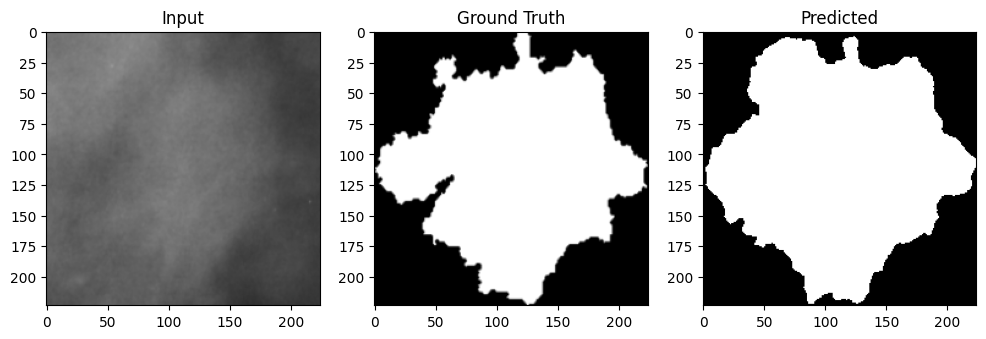

Average IoU score on validation set: 0.8900807048106488
Average Dice score on validation set: 0.9406660582486042


In [ ]:
if run_mode == 'evaluate_model':

  from sklearn.metrics import jaccard_score

  # Function to return back
  def unnormalize(tensor):
      mean = torch.tensor([0.485, 0.456, 0.406])
      std = torch.tensor([0.229, 0.224, 0.225])
      for t, m, s in zip(tensor, mean, std):
          t.mul_(s).add_(m)
      return tensor

  iou_scores = []
  intersections = []
  num_batches = len(val_loader)
  dice_scores = []
  accuracies = []

  with torch.no_grad():
      for i, (inputs, targets) in enumerate(val_loader):
          inputs = inputs.to('cuda')
          targets = targets.to('cuda')
          outputs = model_eval(inputs)
          iou,intersection = iou_score(outputs, targets)
          iou_scores.append(iou.mean()*len(inputs))
          intersections.append(intersection)

          dice = dice_score(outputs, targets)
          dice_scores.append(dice.mean()*len(inputs))

          accuracy = ((outputs.cpu().numpy() > 0.5) == targets.cpu().numpy()).mean()
          accuracies.append(accuracy*len(inputs))

          # dice

          # Plot the first input and output of the first batch
          index = 2
          if i == 1:
              fig, ax = plt.subplots(1, 3, figsize=(12, 6))
              img = unnormalize(inputs[index].cpu())
              ax[0].imshow(img.permute(1, 2, 0))
              ax[0].title.set_text('Input')
              ax[1].imshow(targets[index].cpu().squeeze(),cmap = 'gray')
              ax[1].title.set_text('Ground Truth')
              ax[2].imshow(outputs[index].cpu().squeeze() > 0.5,cmap = 'gray')
              ax[2].title.set_text('Predicted')
              plt.show()

  print(f'Average IoU score on validation set: {sum(iou_scores) / len(y_val)}')
  print(f'Average Dice score on validation set: {sum(dice_scores) / len(y_val)}')

In [ ]:
if run_mode == 'evaluate_model':
